## Import Relevant Libraries

In [40]:
import tensorflow as tf
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import sys

## What versions of libs, python

In [41]:
tf.__version__

'2.2.0'

In [42]:
print(sys.version)

3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]


## Document Where my Images Scraped from Google Are

In [43]:
training_directory = 'image'
training_cat_directory = training_directory + '/cat/'
training_dolphin_directory = training_directory + '/dolphin/'

cat_file_names = os.listdir(training_cat_directory)[:5]
dolphin_file_names = os.listdir(training_dolphin_directory)[-5:]

In [44]:
len(os.listdir(training_cat_directory))

310

In [45]:
cat_file_names

['00436ee451.jpg',
 '0047b99004.jpg',
 '0058af494a.jpg',
 '00e6897f5a.jpg',
 '01a20b5e48.jpg']

In [46]:
def show_images_in_folder(path_to_folder, list_of_files):
    plt.figure(figsize=(10,10))
    resized_image = (100,100)

    for i in range(len(list_of_files)):
        plt.subplot(math.ceil(len(list_of_files)/3), 3, i+1)
        filename = path_to_folder + list_of_files[i]
        
        image = Image.open(filename)
        image = image.resize(resized_image, Image.ANTIALIAS)
        plt.imshow(image, interpolation='bicubic')
        
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

### Let's see how these kitties look

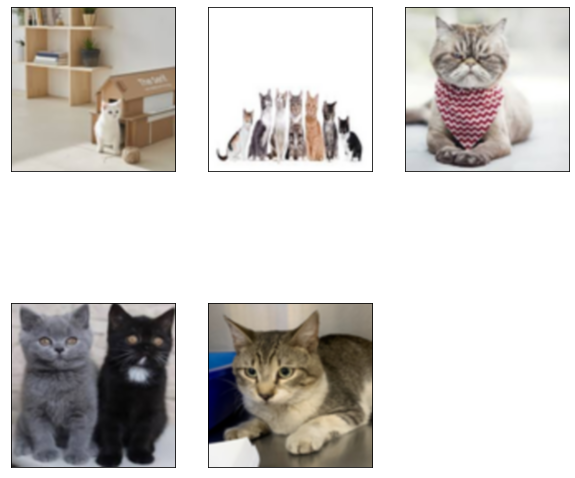

In [47]:
show_images_in_folder(training_cat_directory, cat_file_names)

### Now lets take a look at the dolphins

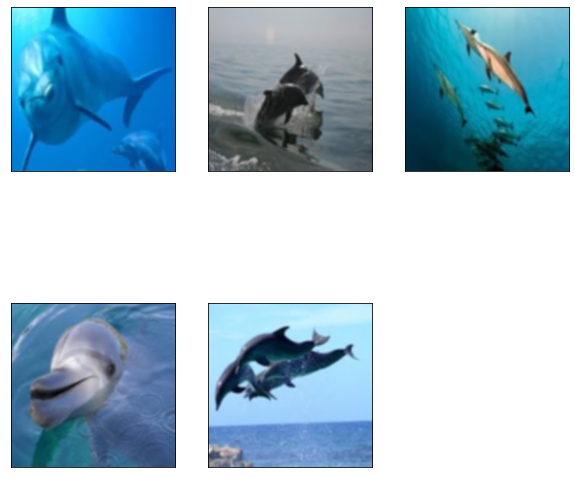

In [48]:
show_images_in_folder(training_dolphin_directory, dolphin_file_names)

## Lets Prep the Data to Be Fed into the Neural Network

Since I don't have that many photos, I will be augementing them to add more training data

In [49]:
ROTATION_RANGE = 90
SHEAR_RANGE = 35
ZOOM_RANGE = 0.75
WIDTH_SHIFT_RANGE = 0.4
HEIGHT_SHIFT_RANGE = 0.4

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=(1/255),
    rotation_range=ROTATION_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
IMG_SIZE = 150
BATCH_SIZE = 128

train_data_generator = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=training_directory,
    shuffle=True,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='binary'
)

Found 654 images belonging to 2 classes.


## Let's see what Augmentation does to an Example Photo

In [51]:
def show_augmented_images(image, **tf_generator_augmentations):
    
    for keyword, value in tf_generator_augmentations.items():
        augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**{keyword:value})

        augmentation.fit(image)

        image_iterator = augmentation.flow(image)

        fig, rows = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
        fig.canvas.set_window_title(keyword + ' of ' + str(value))

        for row in rows:
            row.imshow(image_iterator.next()[0].astype('int'))
            row.axis('off')
            plt.title(keyword + ' of ' + str(value))
        
        plt.show()

### Original Cute Dolphin Photo

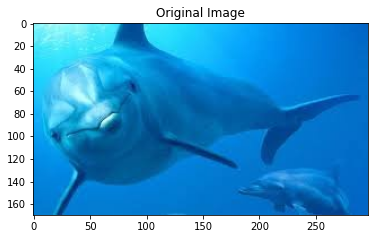

In [52]:
image = plt.imread(training_dolphin_directory + dolphin_file_names[0])
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

plt.imshow(image[0])
plt.title('Original Image')
plt.show()

### Augmented (Not so cute) Dolphin Photos

These can seriously make the dolphin look pretty ugly...see for yourself

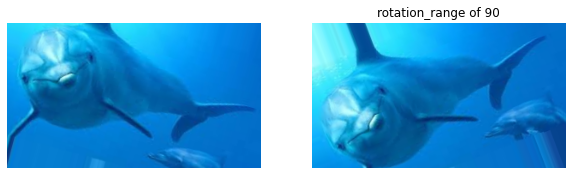

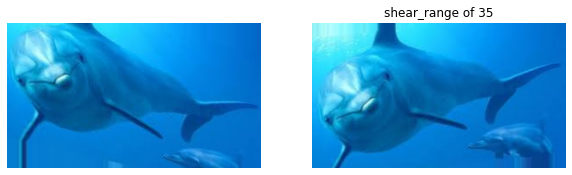

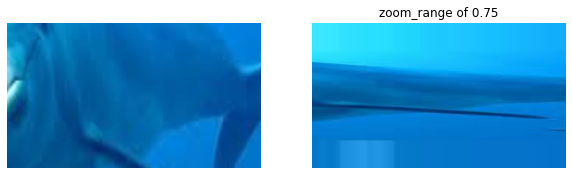

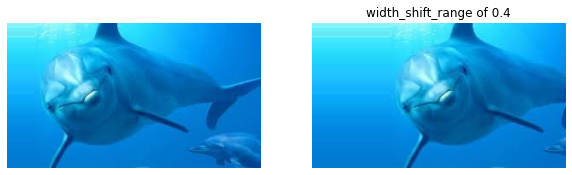

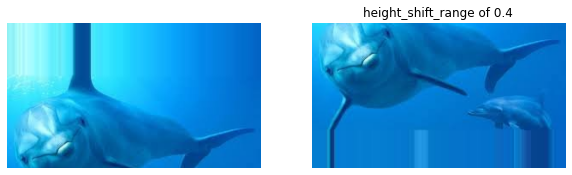

In [53]:
show_augmented_images(image, rotation_range=ROTATION_RANGE, shear_range=SHEAR_RANGE, zoom_range=ZOOM_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE)

## Now Let's Create the Neural Network

I will be using the Google Inception pretrained model, because let's face it I can't train a network that big on my dinky computer. 

It's been trained on millions on photos, and has a very interesting architecture with it's Concetatnation layers.

Thanks Google!

In [54]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

pretrained_inception_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [55]:
pretrained_inception_model.trainable = False

In [56]:
len(pretrained_inception_model.layers)

311

As you can see the Inception model is VERY deep; again impractical for me to train a network this deep

In [57]:
pretrained_inception_model.summary()

161[0][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 7, 7, 192)    576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 7, 7, 192)    576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 7, 7, 192)    576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 7, 7, 192)    576         conv2d_163[0][0]     

## Now I'll add my own top layers, to train Inception to predict for my dataset

In [58]:
model = tf.keras.Sequential([
    pretrained_inception_model,
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),

    tf.keras.layers.Dense(units=1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [59]:
len(model.layers)

4

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 24,162,337
Trainable params: 2,359,553
Non-trainable params: 21,802,784
_________________________________________________________________


## Lets Train

In [61]:
EPOCHS = 10

history = model.fit(
    train_data_generator,
    epochs=EPOCHS
)

Epoch 1/10
6/6 [==============================] - 9s 2s/step - loss: 5.5213 - accuracy: 0.5474
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 0.6191 - accuracy: 0.8471
Epoch 3/10
6/6 [==============================] - 8s 1s/step - loss: 0.4583 - accuracy: 0.8914
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 0.4936 - accuracy: 0.8609
Epoch 5/10
6/6 [==============================] - 10s 2s/step - loss: 0.2716 - accuracy: 0.9220
Epoch 6/10
6/6 [==============================] - 11s 2s/step - loss: 0.2175 - accuracy: 0.9220
Epoch 7/10
6/6 [==============================] - 9s 1s/step - loss: 0.1574 - accuracy: 0.9312
Epoch 8/10
6/6 [==============================] - 8s 1s/step - loss: 0.2221 - accuracy: 0.9235
Epoch 9/10
6/6 [==============================] - 8s 1s/step - loss: 0.1868 - accuracy: 0.9388
Epoch 10/10
6/6 [==============================] - 8s 1s/step - loss: 0.1927 - accuracy: 0.9220


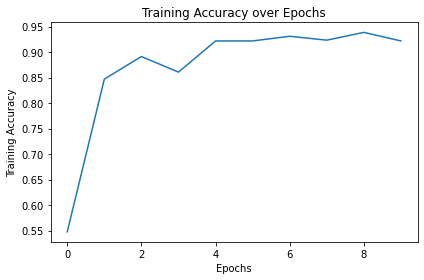

In [62]:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy over Epochs')
plt.ylabel('Training Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()

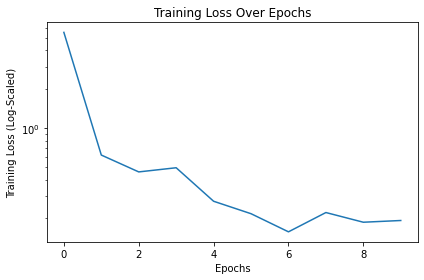

In [63]:
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.ylabel('Training Loss (Log-Scaled)')
plt.xlabel('Epochs')
plt.yscale('log')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()